## NN ODE Solver

Given a general ODE in the form:

$$
\frac{dy}{dx} = f(x, y)
$$

$$
y(0) = k
$$

A custom loss function can be written as follows:

$$
L = \| y' - f(x, y) \|^2 + \| y(0) - k \|^2
$$

If we take the neural network's output prediction to be $N(x, a)$, where $a$ denotes the parameters storing the weights and biases of the model, then we can rewrite the above loss function as:

$$
L(a, x) = \| N'(a, x) - f(x, N(a, x)) \|^2 + \| N(a, 0) - k \|^2
$$

Where $N'(a, x)$ can be calculated through automatic differentiation of the model. Then we can optimize with gradient descent given learning rate $\gamma$ to yield:

$$
a_{n + 1} = a_n - \gamma \nabla L(a, x)
$$

## The ODE

The ODE to be solved is:

$$
\frac{dy}{dx} = -2xy
$$

With the initial condition $y(0) = 1$. The analytical solution is:

$$
y = e^{-x^2}
$$

## Solving the ODE

Original source can be found [here](https://towardsdatascience.com/how-to-solve-an-ode-with-a-neural-network-917d11918932).

In [24]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from jax import jit

In [48]:
def softplus(x):
    return jnp.log(1 + jnp.exp(x))

def model(params, x):
    w0 = params[:80]
    b0 = params[80:160]
    w1 = params[160:240]
    b1 = params[240]
    h = softplus(x*w0 + b0)
    o = np.sum(h*w1) + b1
    return o

# Version of the loss function that allows passing the derivative
# as argument - cannot be JIT accelerated
def deriv_loss(params, derivate, y0, x):
    # Unfortunately it cannot be JIT accelerated as
    # the loss function takes another function as input
    derivative_vect = jax.vmap(derivative, (None, 0))
    eq = dfdx_vect(params, x) + derivative_vect(x, model_vect(params, x))
    bc = model(params, 0) - y0
    return np.mean(eq**2) + bc **2

# Faster and more accurate version of derivative which hardcodes the 
# derivative
# this version can be JIT-accelerated
@jit
def loss(params, y0, x):
    # Unfortunately it cannot be JIT accelerated as
    # the loss function takes another function as input
    derivative_vect = jax.vmap(derivative, (None, 0))
    eq = dfdx_vect(params, x) + 2 * x * model_vect(params, x)
    bc = model(params, 0) - y0
    return np.mean(eq**2) + bc **2

In [49]:
def derivative(x, y):
    return -2 * x * y

In [51]:
key = jax.random.PRNGKey(0)
params = jax.random.normal(key, shape=(241,))

dfdx = jax.grad(model, 1)
model_vect = jax.vmap(model, (None, 0))
dfdx_vect = jax.vmap(dfdx, (None, 0))
grad_loss = jax.jit(jax.grad(loss))

# Defining domain (x)

inputs = jnp.linspace(0, 1, num=401)

# Setting training parameters

epochs = 20000
learning_rate = 0.0005
momentum = 0.99
velocity = 0.

# Training Neural Network

for epoch in tqdm(range(epochs)):
    gradient = grad_loss(params + momentum*velocity, 1., inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

100%|████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1356.39it/s]


In [52]:
model_vect = jax.vmap(linear_model, (None, 0))
preds = model_vect(params, inputs)

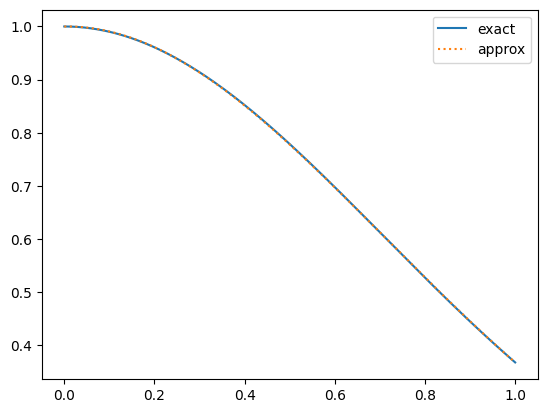

In [53]:
plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, preds, linestyle="dotted", label='approx')
plt.legend()
plt.show()

Compare this to using `solve_ivp` from `scipy.integrate`:

In [299]:
from scipy.integrate import solve_ivp

In [300]:
def dydt(t, y):
    return -2 * t * y

In [301]:
t = jnp.linspace(0, 1, 401)
sol = solve_ivp(dydt, (0, 1), [1], dense_output=True)
y = sol.sol(t)

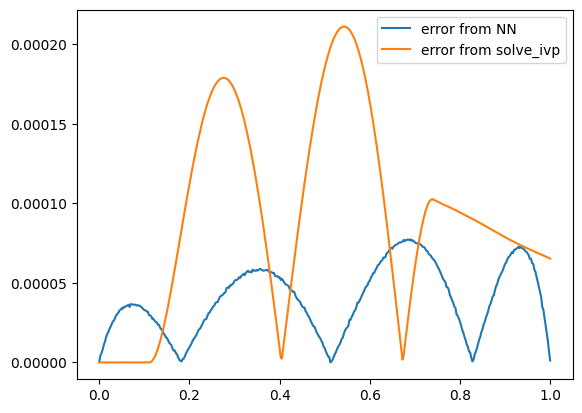

In [302]:
plt.plot(inputs, jnp.abs(np.exp(-inputs**2) - f_vect(params, inputs)), label='error from NN')
plt.plot(t, jnp.abs(np.exp(-inputs**2) - y[0]), label='error from solve_ivp')
plt.legend()
plt.show()

With a higher number of epochs, the neural-network provided solution is more accurate than the solution obtained by `solve_ivp()`.